### Overview

* Added two new methods: LOF novelty detection and isolation_forest
* All results are from cross_val_score(pls) using the validation set with outliers removed
* Methods have the following patterns:
    * LOF_outlier_detection
        * clf.fit_predict(X_validation) -> outlier_indices
        * df_val.drop(outlier_indices)
        * cross_val_score(PLS, df_val.dropped)
    * LOF_novelty_detection
        * clf.fit(X_train)
        * clf.predict(X_validation) -> outlier_indices
        * df_val.drop(outlier_indices)
        * cross_val_score(PLS, df_val.dropped)
    * isolation_forest
        * clf.fit(X_train)
        * clf.predict(X_validation) -> outlier_indices
        * df_val.drop(outlier_indices)
        * cross_val_score(PLS, df_val.dropped)
    * PCA_outliers / PCA_scoring
        * PCA_outliers(X_validation) -> outlier_indices
        * df_val.drop(outlier_indices)
        * cross_val_score(PLS, df_val.dropped)

#### Note:
* Function signatures are misleading, most parameters are not used (only need X_train, X_val,a nd df_val). Noticed this late and did not have time to clean up. 

In [1]:
import pandas as pd
import numpy as np
import statistics as ststc
import scipy.stats as st
from scipy.signal import savgol_filter
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from sklearn.cross_decomposition import PLSRegression
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import warnings
import math
import sys
sys.path.append('../agora')
import agora_lib
from agora_lib import plotting
from agora_lib import prep
import matplotlib.pyplot as plt

In [2]:
def data_processing(path, column_drop_list):
    """Takes an excel file, sets first column as index, drops columns according to column drop_list parameter,
    scales the data with StandardScaler, drops empty rows. Returns a scaled dataframe with only target and spectra."""
    path = path
    xls = pd.ExcelFile(path)
    df = xls.parse()
    df.set_index(df.columns[0], inplace=True)
    df_dropped = df.drop(column_drop_list, axis=1)
    df_dropped.dropna()
    ndarray_SS = StandardScaler().fit_transform(df_dropped)
    df_dropped_SS = pd.DataFrame(ndarray_SS)
    df_dropped_SS.dropna(inplace=True)
    return df_dropped_SS

def data_processing_parse(path):
    """Same as data_processing, but deals with multi-tab formatted excel (per standard Agora submission)"""
    xls = pd.ExcelFile(path)
    Y_df = xls.parse(sheet_name='Reference Data (Y)')
    X_df = xls.parse(sheet_name='Raw Spectra (X)')
    Y_df.set_index(Y_df.columns[0], inplace=True)
    X_df.set_index(X_df.columns[0], inplace=True)
    df_concat = pd.concat([Y_df, X_df], axis=1)
    df_concat_nd = StandardScaler().fit_transform(df_concat)
    df_concat_df = pd.DataFrame(df_concat_nd)
    df_concat_df.dropna(inplace=True)
    return df_concat_df

def frame_parse(df):
    X = df.iloc[:, 1:]
    Y = df.iloc[:, 0]
    return X, Y

def data_splitter(df):
    X = df.iloc[:, 1:]
    Y = df.iloc[:, 0]
    X_train, X_dev, y_train, y_dev = train_test_split(X, Y, test_size=0.20)
    df_train = pd.concat([X_train, y_train], axis=1)
    return X_train, X_dev, y_train, y_dev, df_train

#Stand alone sav_gol filter
def sav_gol_filter(df):
    #work out later
    return df

#Stand alone scaler (some datasets already scaled)
def Standard_scale_df(df):
    #work out later
    return df

def LOF_outlier_detection(X_train, X_val, y_train, y_val, df_val, range_neighbors):
    list_num_outliers_dropped = []
    list_r2_val_set = []
    list_temp_mse_scores = []
    list_neg_mse_val_set = []
    list_pos_mse_val_set = []
    dict_return = {}
    for n in range_neighbors:
        #initiate the LOF classifier with num_neighbors per the loop
        clf = LocalOutlierFactor(n_neighbors=n)
        #use fit_predict(X_train) for straight-forward outlier detection
        LOF_outlier_flags = clf.fit_predict(X_val)
        #get a list of outliers and use it to drop rows from df_train
        lst_outl_indices = [i for i,item in enumerate(LOF_outlier_flags) if item < 0]
        list_num_outliers_dropped.append(len(lst_outl_indices))
        #drop outliers from the validation dataframe
        df_drop = df_val.drop(df_val.index[lst_outl_indices])
        X_pls = df_drop.iloc[:,1:]
        y_pls = df_drop.iloc[:,0]
        #fit the pls the training partition without outliers
        pls1 = PLSRegression(n_components=5)
        r2_score_val_set = np.mean(cross_val_score(pls1, X_pls, y_pls, cv=5, scoring='r2', n_jobs=-1))
        list_r2_val_set.append(r2_score_val_set)
        list_temp_mse_scores = cross_val_score(pls1, X_pls, y_pls, cv=5, scoring='neg_mean_squared_error',
                                                      n_jobs=-1)
        list_neg_mse_val_set.append(np.mean(list_temp_mse_scores))
        list_pos_mse_val_set.append(np.mean([-1*x for x in list_temp_mse_scores]))

        dict_return = {'num_neighbors':range_neighbors, 'num_outliers_dropped':list_num_outliers_dropped,
                        'r2_CV_score_validation': list_r2_val_set,
                        'mse_CV_score_validation': list_pos_mse_val_set}
    return dict_return

def LOF_novelty_detection(X_train, X_val, y_train, y_val, df_val, range_neighbors):
    list_num_outliers_dropped = []
    list_r2_val_set = []
    list_temp_mse_scores = []
    list_neg_mse_val_set = []
    list_pos_mse_val_set = []
    dict_return = {}
    for n in range_neighbors:
        #initiate the LOF classifier with num_neighbors per the loop; novelty=True for nov detection
        clf = LocalOutlierFactor(n_neighbors=n, novelty=True)
        #train the LOF on X_train
        clf.fit(X_train)
        LOF_outlier_flags = clf.predict(X_val)
        #get a list of outliers and use it to drop rows from df_train
        lst_outl_indices = [i for i,item in enumerate(LOF_outlier_flags) if item < 0]
        list_num_outliers_dropped.append(len(lst_outl_indices))
        #drop outliers from the validation dataframe
        df_drop = df_val.drop(df_val.index[lst_outl_indices])
        X_pls = df_drop.iloc[:,1:]
        y_pls = df_drop.iloc[:,0]
        #fit the pls the training partition without outliers
        pls1 = PLSRegression(n_components=5)
        r2_score_val_set = np.mean(cross_val_score(pls1, X_pls, y_pls, cv=5, scoring='r2', n_jobs=-1))
        list_r2_val_set.append(r2_score_val_set)
        list_temp_mse_scores = cross_val_score(pls1, X_pls, y_pls, cv=5, scoring='neg_mean_squared_error',
                                                      n_jobs=-1)
        list_neg_mse_val_set.append(np.mean(list_temp_mse_scores))
        list_pos_mse_val_set.append(np.mean([-1*x for x in list_temp_mse_scores]))

        dict_return = {'num_neighbors':range_neighbors, 'num_outliers_dropped':list_num_outliers_dropped,
                        'r2_CV_score_validation': list_r2_val_set,
                        'mse_CV_score_validation': list_pos_mse_val_set}
    return dict_return

def isolation_forest(X_train, X_val, y_train, y_val, df_val, range_estimators):
    list_num_outliers_dropped = []
    list_r2_val_set = []
    list_temp_mse_scores = []
    list_neg_mse_val_set = []
    list_pos_mse_val_set = []
    dict_return = {}
    for n in range_estimators:
        #initiate the isolation forest
        clf = IsolationForest(n_estimators=n)
        clf.fit(X_train)
        forest_outlier_flags = clf.predict(X_val)
        #get a list of outliers and use it to drop rows from df_train
        lst_outl_indices = [i for i,item in enumerate(forest_outlier_flags) if item < 0]
        list_num_outliers_dropped.append(len(lst_outl_indices))
        #drop outliers from the validation dataframe
        df_drop = df_val.drop(df_val.index[lst_outl_indices])
        X_pls = df_drop.iloc[:,1:]
        y_pls = df_drop.iloc[:,0]
        #fit the pls the training partition without outliers
        pls1 = PLSRegression(n_components=5)
        r2_score_val_set = np.mean(cross_val_score(pls1, X_pls, y_pls, cv=5, scoring='r2', n_jobs=-1))
        list_r2_val_set.append(r2_score_val_set)
        list_temp_mse_scores = cross_val_score(pls1, X_pls, y_pls, cv=5, scoring='neg_mean_squared_error',
                                                      n_jobs=-1)
        list_neg_mse_val_set.append(np.mean(list_temp_mse_scores))
        list_pos_mse_val_set.append(np.mean([-1*x for x in list_temp_mse_scores]))

        dict_return = {'num_neighbors':range_estimators, 'num_outliers_dropped':list_num_outliers_dropped,
                        'r2_CV_score_validation': list_r2_val_set,
                        'mse_CV_score_validation': list_pos_mse_val_set}
    return dict_return

def PCA_outliers(X_df):
    list_of_list_outliers = []
    x_df_index = X_df.index.values.tolist()
    #Set up principal component DataFrame - use only spectra
    pca = PCA(n_components=6)
    principalComponents = pca.fit_transform(X_df)
    principalDf = pd.DataFrame(data=principalComponents, columns=['principal component 1', 'principal component 2',
                                                                  'principal component 3', 'principal component 4',
                                                                  'principal component 5', 'principal component 6'])
    # run calculate_distances() on the main principal df for the PC1 vs PC2 combination
    principalDf = prep.calculate_distances(principalDf,"Distance: PC1&PC2", "principal component 1",
                                 "principal component 2")
    # use the best_fit_distribution method to calculate the p-value on the distances between PCs
    best_fit_name_1_2, best_fit_params_1_2, best_fit_int_1_2 = plotting.best_fit_distribution(principalDf["Distance: PC1&PC2"], 200)
    index_list_PC1_2 = []
    for i in range(len(principalDf)):
        if principalDf.loc[i, "Distance: PC1&PC2"] > best_fit_int_1_2[1]:
            index_list_PC1_2.append(i)
    list_of_list_outliers.append(index_list_PC1_2)
    
    principalDf = prep.calculate_distances(principalDf,"Distance: PC3&PC4", "principal component 3",
                                 "principal component 4")
    # use the best_fit_distribution method to calculate the p-value on the distances between PCs
    best_fit_name_3_4, best_fit_params_3_4, best_fit_int_3_4 = plotting.best_fit_distribution(principalDf["Distance: PC3&PC4"], 200)
    index_list_PC3_4 = []
    for i in range(len(principalDf)):
        if principalDf.loc[i, "Distance: PC3&PC4"] > best_fit_int_3_4[1]:
            index_list_PC3_4.append(i)
    list_of_list_outliers.append(index_list_PC3_4)
    
    principalDf = prep.calculate_distances(principalDf,"Distance: PC5&PC6", "principal component 5",
                                 "principal component 6")
    # use the best_fit_distribution method to calculate the p-value on the distances between PCs
    best_fit_name_5_6, best_fit_params_5_6, best_fit_int_5_6 = plotting.best_fit_distribution(principalDf["Distance: PC5&PC6"], 200)
    index_list_PC5_6 = []
    for i in range(len(principalDf)):
        if principalDf.loc[i, "Distance: PC5&PC6"] > best_fit_int_5_6[1]:
            index_list_PC5_6.append(i)
    list_of_list_outliers.append(index_list_PC5_6)

    return list_of_list_outliers

def PCA_scoring(list_of_list_outliers, X_val, y_val, df_val):
    list_PCA_combo = ['PC1&PC2', 'PC3&PC4', 'PC5&PC6']
    list_num_outliers_dropped = []
    lst_of_PCA_dfs = []
    list_temp_mse_scores = []
    list_neg_mse_test = []
    list_pos_mse_test = []
    list_r2_test = []
   
    dict_return = {}
    for lst_indices in list_of_list_outliers:
        df_dropped = df_val.drop(df_val.index[lst_indices]) 
        lst_of_PCA_dfs.append(df_dropped)
        list_num_outliers_dropped.append(len(lst_indices))
    for df in lst_of_PCA_dfs:
        X_pls = df.iloc[:,1:]
        y_pls = df.iloc[:,0]
        pls1 = PLSRegression(n_components=5)
        list_temp_mse_scores = cross_val_score(pls1, X_pls, y_pls, cv=5, scoring='neg_mean_squared_error',
                                                      n_jobs=-1)
        list_neg_mse_test.append(np.mean(list_temp_mse_scores))
        list_pos_mse_test.append(np.mean([-1*x for x in list_temp_mse_scores]))
        list_r2_test.append(np.mean(cross_val_score(pls1, X_pls, y_pls, cv=5, scoring='r2', n_jobs=-1)))

    dict_return = {'PCA combo':list_PCA_combo, 'num_outliers_dropped':list_num_outliers_dropped,
                        'r2_CV_score_validation': list_r2_test,
                        'mse_CV_score_validation': list_pos_mse_test}
    return dict_return    
     

In [3]:
#Dataframe columns to be dropped for data_processing()
list_proteinDf_drop_columns_train = ['pH (measured)', 'Osmo  (measured)', 'PS20 (measured)','Met (measured)'
                            ,'pH (target)', 'Protein Concentration  (target)', 'PS20 (target)','Met (target)']
list_osmoDf_drop_columns_train = ['pH (measured)', 'Protein Concentration  (measured)', 'PS20 (measured)','Met (measured)'
                            ,'pH (target)', 'Protein Concentration  (target)', 'PS20 (target)','Met (target)']

list_proteinDf_drop_columns_val = ['pH (measured)', 'Osmo  (measured)', 'PS20 (measured)','Met (measured)']
list_osmoDf_drop_columns_val = ['pH (measured)', 'Protein Concentration  (measured)', 'PS20 (measured)','Met (measured)']


In [4]:
path_train = "Formulation_DOE_Merged_Data_design_targets_v2.xlsx"
path_val = "Mock_Validation_Dataset.xlsx"

path_gluc_train = "Agora_Submission_Glucose_Val.xlsx"
path_gluc_val = "Agora_Submission_Glucose_ValSet.xlsx"



In [5]:
#datasets needing complumns removed
df_protein_train = data_processing(path_train, list_proteinDf_drop_columns_train)
df_protein_val = data_processing(path_val, list_proteinDf_drop_columns_val)
df_osmo_train = data_processing(path_train, list_osmoDf_drop_columns_train)
df_osmo_val = data_processing(path_val, list_osmoDf_drop_columns_val)
#datasets parsed per sheet
df_glucose_train = data_processing_parse(path_gluc_train)
df_glucose_val = data_processing_parse(path_gluc_val)



In [6]:
range_protein_osmo_train = [20,40,60,80,100]
X_protein_train, y_protein_train = frame_parse(df_protein_train)
X_protein_val, y_protein_val = frame_parse(df_protein_val)


In [7]:
#LOF outlier detection method
dict_return_protein_OD = LOF_outlier_detection(X_protein_train, X_protein_val, y_protein_train, y_protein_val, 
                                  df_protein_val, range_protein_osmo_train) 
print("LOF Outlier Detection Method - Formulation DOE Protein target")
protein_display_OD = pd.DataFrame(dict_return_protein_OD)
protein_display_OD


LOF Outlier Detection Method - Formulation DOE Protein target


,num_neighbors,num_outliers_dropped,r2_CV_score_validation,mse_CV_score_validation
0,20,2,0.938630,0.030635
1,40,2,0.938630,0.030635
2,60,0,0.922872,0.046402
3,80,0,0.922872,0.046402
4,100,0,0.922872,0.046402


In [8]:
#LOF novelty detection method
dict_return_protein_nov = LOF_novelty_detection(X_protein_train, X_protein_val, y_protein_train, y_protein_val, 
                                  df_protein_val, range_protein_osmo_train) 
print("LOF Novelty Detection Method - Formulation DOE Protein target")
protein_display_nov = pd.DataFrame(dict_return_protein_nov)
protein_display_nov


LOF Novelty Detection Method - Formulation DOE Protein target


,num_neighbors,num_outliers_dropped,r2_CV_score_validation,mse_CV_score_validation
0,20,4,0.962100,0.016620
1,40,3,0.969100,0.017106
2,60,4,0.911521,0.034244
3,80,5,0.900366,0.036594
4,100,5,0.900366,0.036594


In [9]:
#Isolation Forest detection method
dict_return_protein_IF = isolation_forest(X_protein_train, X_protein_val, y_protein_train, y_protein_val, 
                                  df_protein_val, range_protein_osmo_train) 
print("Isolation Forest Outlier Detection Method - Formulation DOE Protein target")
protein_display_IF = pd.DataFrame(dict_return_protein_IF)
protein_display_IF


Isolation Forest Outlier Detection Method - Formulation DOE Protein target


,num_neighbors,num_outliers_dropped,r2_CV_score_validation,mse_CV_score_validation
0,20,15,0.794674,0.043127
1,40,15,0.829203,0.036996
2,60,13,0.818470,0.037867
3,80,18,0.835359,0.034426
4,100,13,0.829347,0.038265


In [14]:
#Compare to PCA
list_protein_PCA_outliers = PCA_outliers(X_protein_train)
dict_return_protein_PCA = PCA_scoring(list_protein_PCA_outliers, X_protein_val, y_protein_val, df_protein_train)
protein_display_PCA = pd.DataFrame(dict_return_protein_PCA)
protein_display_PCA


,PCA combo,num_outliers_dropped,r2_CV_score_validation,mse_CV_score_validation
0,PC1&PC2,14,0.926968,0.028072
1,PC3&PC4,10,0.912113,0.029454
2,PC5&PC6,13,0.904096,0.058845


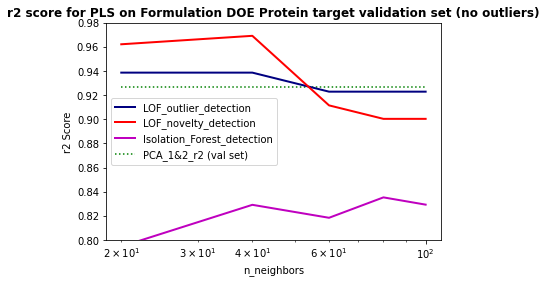

In [15]:
param_range = range_protein_osmo_train
plt.title("r2 score for PLS on Formulation DOE Protein target validation set (no outliers)", fontweight="bold")
plt.xlabel("n_neighbors")
plt.ylabel("r2 Score")
plt.ylim(0.80, 0.98)
lw = 2
plt.semilogx(param_range, protein_display_OD['r2_CV_score_validation'], label="LOF_outlier_detection",
             color="navy", lw=lw)

plt.semilogx(param_range, protein_display_nov['r2_CV_score_validation'], label="LOF_novelty_detection",
             color="red", lw=lw)

plt.semilogx(param_range, protein_display_IF['r2_CV_score_validation'], label="Isolation_Forest_detection",
             color="m", lw=lw)

#PC1 v PC2 score
plt.hlines(protein_display_PCA.loc[0, 'r2_CV_score_validation'],param_range[0], param_range[-1], color='g', 
           linestyle=':', label="PCA_1&2_r2 (val set)")
plt.legend(loc="best")
plt.show()


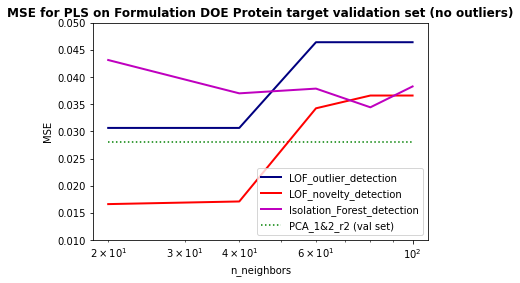

In [16]:
param_range = range_protein_osmo_train
plt.title("MSE for PLS on Formulation DOE Protein target validation set (no outliers)", fontweight="bold")
plt.xlabel("n_neighbors")
plt.ylabel("MSE")
plt.ylim(0.01, 0.05)
lw = 2
plt.semilogx(param_range, protein_display_OD['mse_CV_score_validation'], label="LOF_outlier_detection",
             color="navy", lw=lw)

plt.semilogx(param_range, protein_display_nov['mse_CV_score_validation'], label="LOF_novelty_detection",
             color="red", lw=lw)

plt.semilogx(param_range, protein_display_IF['mse_CV_score_validation'], label="Isolation_Forest_detection",
             color="m", lw=lw)

#PC1 v PC2 score
plt.hlines(protein_display_PCA.loc[0, 'mse_CV_score_validation'],param_range[0], param_range[-1], color='g', 
           linestyle=':', label="PCA_1&2_r2 (val set)")
plt.legend(loc="best")
plt.show()


In [17]:
range_protein_osmo_train = [20,40,60,80,100]
X_osmo_train, y_osmo_train = frame_parse(df_osmo_train)
X_osmo_val, y_osmo_val = frame_parse(df_osmo_val)

In [18]:
#LOF outlier detection method
dict_return_osmo_OD = LOF_outlier_detection(X_osmo_train, X_osmo_val, y_osmo_train, y_osmo_val, 
                                  df_osmo_val, range_protein_osmo_train) 

print("LOF Outlier Detection Method - Formulation DOE Osmo target")
osmo_display_OD = pd.DataFrame(dict_return_osmo_OD)
osmo_display_OD

LOF Outlier Detection Method - Formulation DOE Osmo target


,num_neighbors,num_outliers_dropped,r2_CV_score_validation,mse_CV_score_validation
0,20,2,0.935734,0.031454
1,40,2,0.935734,0.031454
2,60,0,0.927833,0.056543
3,80,0,0.927833,0.056543
4,100,0,0.927833,0.056543


In [19]:
#LOF novelty detection method
dict_return_osmo_nov = LOF_novelty_detection(X_osmo_train, X_osmo_val, y_osmo_train, y_osmo_val, 
                                  df_osmo_val, range_protein_osmo_train) 

print("LOF Novelty Detection Method - Formulation DOE Osmo target")
osmo_display_nov = pd.DataFrame(dict_return_osmo_nov)
osmo_display_nov

LOF Novelty Detection Method - Formulation DOE Osmo target


,num_neighbors,num_outliers_dropped,r2_CV_score_validation,mse_CV_score_validation
0,20,4,0.914584,0.045818
1,40,3,0.929086,0.033448
2,60,4,0.938383,0.034017
3,80,5,0.934188,0.035160
4,100,5,0.934188,0.035160


In [20]:
#Isolation Forest detection method
dict_return_osmo_IF = isolation_forest(X_osmo_train, X_osmo_val, y_osmo_train, y_osmo_val, 
                                  df_osmo_val, range_protein_osmo_train) 

print("Isolation Forest Outlier Detection Method - Formulation DOE Osmo target")
osmo_display_IF = pd.DataFrame(dict_return_osmo_IF)
osmo_display_IF

Isolation Forest Outlier Detection Method - Formulation DOE Osmo target


,num_neighbors,num_outliers_dropped,r2_CV_score_validation,mse_CV_score_validation
0,20,15,0.901859,0.037153
1,40,14,0.935414,0.027549
2,60,13,0.923371,0.031642
3,80,13,0.895966,0.036686
4,100,16,0.915823,0.031356


In [21]:
#Compare to PCA
list_osmo_PCA_outliers = PCA_outliers(X_osmo_val)
dict_return_osmo_PCA = PCA_scoring(list_osmo_PCA_outliers, X_osmo_val, y_osmo_val, df_osmo_val)

print("PCA Outlier Detection Method - Formulation DOE Protein target")
osmo_display_PCA = pd.DataFrame(dict_return_osmo_PCA)
osmo_display_PCA

PCA Outlier Detection Method - Formulation DOE Protein target


,PCA combo,num_outliers_dropped,r2_CV_score_validation,mse_CV_score_validation
0,PC1&PC2,2,0.935734,0.031454
1,PC3&PC4,1,0.940725,0.034126
2,PC5&PC6,3,0.939144,0.046622


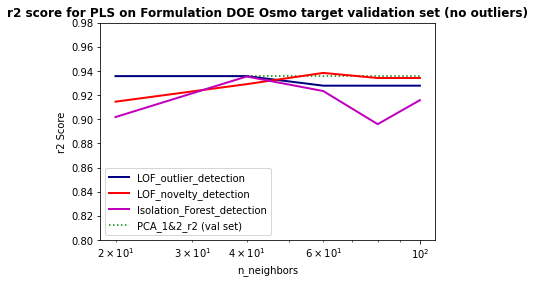

In [22]:
param_range = range_protein_osmo_train
plt.title("r2 score for PLS on Formulation DOE Osmo target validation set (no outliers)", fontweight="bold")
plt.xlabel("n_neighbors")
plt.ylabel("r2 Score")
plt.ylim(0.80, 0.98)
lw = 2
plt.semilogx(param_range, osmo_display_OD['r2_CV_score_validation'], label="LOF_outlier_detection",
             color="navy", lw=lw)

plt.semilogx(param_range, osmo_display_nov['r2_CV_score_validation'], label="LOF_novelty_detection",
             color="red", lw=lw)

plt.semilogx(param_range, osmo_display_IF['r2_CV_score_validation'], label="Isolation_Forest_detection",
             color="m", lw=lw)

#PC1 v PC2 score
plt.hlines(osmo_display_PCA.loc[0, 'r2_CV_score_validation'],param_range[0], param_range[-1], color='g', 
           linestyle=':', label="PCA_1&2_r2 (val set)")
plt.legend(loc="best")
plt.show()

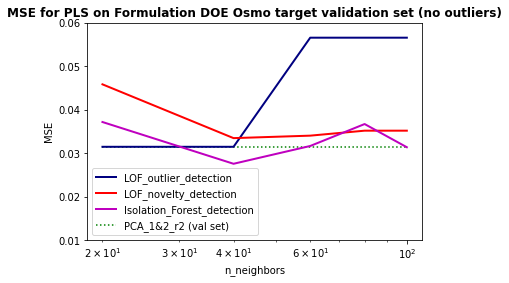

In [23]:
param_range = range_protein_osmo_train
plt.title("MSE for PLS on Formulation DOE Osmo target validation set (no outliers)", fontweight="bold")
plt.xlabel("n_neighbors")
plt.ylabel("MSE")
plt.ylim(0.01, 0.06)
lw = 2
plt.semilogx(param_range, osmo_display_OD['mse_CV_score_validation'], label="LOF_outlier_detection",
             color="navy", lw=lw)

plt.semilogx(param_range, osmo_display_nov['mse_CV_score_validation'], label="LOF_novelty_detection",
             color="red", lw=lw)

plt.semilogx(param_range, osmo_display_IF['mse_CV_score_validation'], label="Isolation_Forest_detection",
             color="m", lw=lw)

#PC1 v PC2 score
plt.hlines(osmo_display_PCA.loc[0, 'mse_CV_score_validation'],param_range[0], param_range[-1], color='g', 
           linestyle=':', label="PCA_1&2_r2 (val set)")
plt.legend(loc="best")
plt.show()

In [24]:
range_neighbors_gluc_train = [20,40,60,80,100]
X_glucose_train, y_glucose_train = frame_parse(df_glucose_train)
X_glucose_val, y_glucose_val = frame_parse(df_glucose_val)

In [25]:
#LOF outlier detection method
dict_return_glucose_OD = LOF_outlier_detection(X_glucose_train, X_glucose_val, y_glucose_train, y_glucose_val, 
                                  df_glucose_val, range_neighbors_gluc_train) 

print("LOF Outlier Detection Method - Agora_Submission_Glucose_ValSet")
glucose_display_OD = pd.DataFrame(dict_return_glucose_OD)
glucose_display_OD

LOF Outlier Detection Method - Agora_Submission_Glucose_ValSet


,num_neighbors,num_outliers_dropped,r2_CV_score_validation,mse_CV_score_validation
0,20,4,0.452777,0.313713
1,40,14,0.532427,0.310756
2,60,25,0.626222,0.239769
3,80,25,0.626222,0.239769
4,100,25,0.626222,0.239769


In [26]:
#LOF novelty detection method
dict_return_glucose_nov = LOF_novelty_detection(X_glucose_train, X_glucose_val, y_glucose_train, y_glucose_val, 
                                  df_glucose_val, range_neighbors_gluc_train) 

print("LOF Novelty Detection Method - Agora_Submission_Glucose_ValSet")
glucose_display_nov = pd.DataFrame(dict_return_glucose_nov)
glucose_display_nov

LOF Novelty Detection Method - Agora_Submission_Glucose_ValSet


,num_neighbors,num_outliers_dropped,r2_CV_score_validation,mse_CV_score_validation
0,20,58,0.236199,0.418631
1,40,46,0.473870,0.340357
2,60,39,0.557020,0.304640
3,80,37,0.553104,0.307066
4,100,35,0.565399,0.304415


In [27]:
#Isolation Forest detection method
dict_return_glucose_IF = isolation_forest(X_glucose_train, X_glucose_val, y_glucose_train, y_glucose_val, 
                                  df_glucose_val, range_neighbors_gluc_train) 

print("Isolation Forest Outlier Detection Method - Agora_Submission_Glucose_ValSet")
glucose_display_IF = pd.DataFrame(dict_return_glucose_IF)
glucose_display_IF

Isolation Forest Outlier Detection Method - Agora_Submission_Glucose_ValSet


,num_neighbors,num_outliers_dropped,r2_CV_score_validation,mse_CV_score_validation
0,20,45,0.680814,0.219076
1,40,42,0.648023,0.232510
2,60,42,0.676755,0.219267
3,80,40,0.676368,0.219699
4,100,38,0.631826,0.250344


In [28]:
#Compare to PCA
list_glucose_PCA_outliers = PCA_outliers(X_glucose_val)
dict_return_glucose_PCA = PCA_scoring(list_glucose_PCA_outliers, X_glucose_val, y_glucose_val, df_glucose_val)

print("PCA Outlier Detection Method - Agora_Submission_Glucose_ValSet")
glucose_display_PCA = pd.DataFrame(dict_return_glucose_PCA)
glucose_display_PCA

PCA Outlier Detection Method - Agora_Submission_Glucose_ValSet


,PCA combo,num_outliers_dropped,r2_CV_score_validation,mse_CV_score_validation
0,PC1&PC2,12,0.564219,0.293048
1,PC3&PC4,9,0.450806,0.337968
2,PC5&PC6,7,0.496190,0.325142


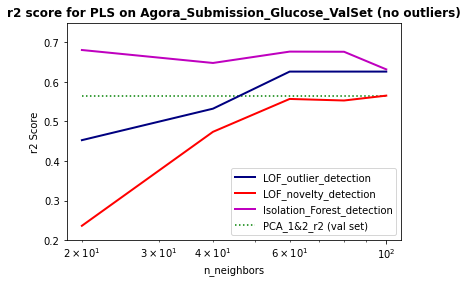

In [29]:
param_range = range_neighbors_gluc_train
plt.title("r2 score for PLS on Agora_Submission_Glucose_ValSet (no outliers)", fontweight="bold")
plt.xlabel("n_neighbors")
plt.ylabel("r2 Score")
plt.ylim(0.20, 0.75)
lw = 2
plt.semilogx(param_range, glucose_display_OD['r2_CV_score_validation'], label="LOF_outlier_detection",
             color="navy", lw=lw)

plt.semilogx(param_range, glucose_display_nov['r2_CV_score_validation'], label="LOF_novelty_detection",
             color="red", lw=lw)

plt.semilogx(param_range, glucose_display_IF['r2_CV_score_validation'], label="Isolation_Forest_detection",
             color="m", lw=lw)

#PC1 v PC2 score
plt.hlines(glucose_display_PCA.loc[0, 'r2_CV_score_validation'],param_range[0], param_range[-1], color='g', 
           linestyle=':', label="PCA_1&2_r2 (val set)")
plt.legend(loc="best")
plt.show()

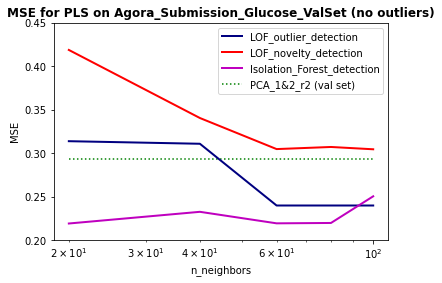

In [30]:
param_range = range_neighbors_gluc_train
plt.title("MSE for PLS on Agora_Submission_Glucose_ValSet (no outliers)", fontweight="bold")
plt.xlabel("n_neighbors")
plt.ylabel("MSE")
plt.ylim(0.20, 0.45)
lw = 2
plt.semilogx(param_range, glucose_display_OD['mse_CV_score_validation'], label="LOF_outlier_detection",
             color="navy", lw=lw)

plt.semilogx(param_range, glucose_display_nov['mse_CV_score_validation'], label="LOF_novelty_detection",
             color="red", lw=lw)

plt.semilogx(param_range, glucose_display_IF['mse_CV_score_validation'], label="Isolation_Forest_detection",
             color="m", lw=lw)

#PC1 v PC2 score
plt.hlines(glucose_display_PCA.loc[0, 'mse_CV_score_validation'],param_range[0], param_range[-1], color='g', 
           linestyle=':', label="PCA_1&2_r2 (val set)")
plt.legend(loc="best")
plt.show()